# Manufacturing Defects

In [ ]:
# Challenges
# -------------------
# Imbalanced Data:
# The dataset initially had an unequal distribution of severity levels. SMOTE helped balance the training set, but the test set's real-world imbalance may have affected performance.

# Limited Feature Complexity:
# The available features may not fully capture all the factors influencing severity, such as environmental conditions, production process details, or operator expertise.

# Model Performance:
# The models' accuracy and F1 scores (~30%) suggest that the problem is challenging and may require additional features or more advanced algorithms to improve predictions.

# Potential Overfitting in Initial Efforts:
# Previous results with perfect evaluation metrics (100% accuracy) indicated overfitting or data leakage. These issues were addressed by using SMOTE, stratified splits, and careful cross-validation.



# Conclusion
# -------------------
# While the project successfully applied machine learning to analyze manufacturing defects and predict severity, the moderate performance metrics highlight areas for improvement. The following steps could enhance the results:

# Collecting more features relevant to defect severity (e.g., material properties, production line details).
# Leveraging more advanced algorithms, such as neural networks, or domain-specific models.
# Exploring ensemble methods or stacked models for better predictions.
# Enhancing interpretability with domain-specific rules to supplement machine learning models.

# The project demonstrates the potential of machine learning in quality control but also emphasizes the need for more detailed data and advanced methods to achieve high accuracy in real-world applications.

In [3]:
!pip install xgboost

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import zipfile
import joblib
from imblearn.over_sampling import SMOTE

In [6]:
# Step 1: Extract Data from Zip File
zip_file_path = 'Manufacturing Defects.zip'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall()
    extracted_files = zip_ref.namelist()
    print("Files extracted from Manufacturing Defects.zip:", extracted_files)

# Load the CSV file
csv_file_name = extracted_files[0]  # Assuming single CSV file
df = pd.read_csv(csv_file_name)

# Inspect the first few rows
print("\nInitial Dataset Overview:")
print(df.head())

# Dataset information
print("\nDataset Info:")
print(df.info())

Files extracted from Manufacturing Defects.zip: ['defects_data.csv']

Initial Dataset Overview:
   defect_id  product_id defect_type defect_date defect_location  severity  \
0          1          15  Structural    6/6/2024       Component     Minor   
1          2           6  Functional   4/26/2024       Component     Minor   
2          3          84  Structural   2/15/2024        Internal     Minor   
3          4          10  Functional   3/28/2024        Internal  Critical   
4          5          14    Cosmetic   4/26/2024       Component     Minor   

   inspection_method  repair_cost  
0  Visual Inspection       245.47  
1  Visual Inspection        26.87  
2  Automated Testing       835.81  
3  Automated Testing       444.47  
4     Manual Testing       823.64  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0 

In [7]:
# Data Cleaning and Feature Engineering

# Convert 'defect_date' to datetime
df['defect_date'] = pd.to_datetime(df['defect_date'], errors='coerce')

# Extract features from defect_date
df['defect_year'] = df['defect_date'].dt.year
df['defect_month'] = df['defect_date'].dt.month
df['defect_day'] = df['defect_date'].dt.day

# Drop defect_date (redundant after extraction)
df.drop(columns=['defect_date'], inplace=True)

# Inspect missing values
print("\nMissing Values Before Cleaning:")
print(df.isnull().sum())

# Handle categorical columns using Label Encoding
categorical_columns = ['defect_type', 'defect_location', 'inspection_method', 'severity']
label_encoders = {}

for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Inspect Label Encodings
for col, le in label_encoders.items():
    print(f"\nLabel Encoding for {col}:")
    print(dict(zip(le.classes_, le.transform(le.classes_))))

# Inspect cleaned dataset
print("\nCleaned Dataset Head:")
print(df.head())


Missing Values Before Cleaning:
defect_id            0
product_id           0
defect_type          0
defect_location      0
severity             0
inspection_method    0
repair_cost          0
defect_year          0
defect_month         0
defect_day           0
dtype: int64

Label Encoding for defect_type:
{'Cosmetic': 0, 'Functional': 1, 'Structural': 2}

Label Encoding for defect_location:
{'Component': 0, 'Internal': 1, 'Surface': 2}

Label Encoding for inspection_method:
{'Automated Testing': 0, 'Manual Testing': 1, 'Visual Inspection': 2}

Label Encoding for severity:
{'Critical': 0, 'Minor': 1, 'Moderate': 2}

Cleaned Dataset Head:
   defect_id  product_id  defect_type  defect_location  severity  \
0          1          15            2                0         1   
1          2           6            1                0         1   
2          3          84            2                1         1   
3          4          10            1                1         0   
4          5 

Dataset Shape: (1000, 10)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   defect_id          1000 non-null   int64  
 1   product_id         1000 non-null   int64  
 2   defect_type        1000 non-null   int32  
 3   defect_location    1000 non-null   int32  
 4   severity           1000 non-null   int32  
 5   inspection_method  1000 non-null   int32  
 6   repair_cost        1000 non-null   float64
 7   defect_year        1000 non-null   int32  
 8   defect_month       1000 non-null   int32  
 9   defect_day         1000 non-null   int32  
dtypes: float64(1), int32(7), int64(2)
memory usage: 50.9 KB

Summary Statistics:
         defect_id   product_id  defect_type  defect_location    severity  \
count  1000.000000  1000.000000  1000.000000      1000.000000  1000.00000   
mean    500.500000    50.837000     1.043

C:\Users\milto\AppData\Local\Temp\ipykernel_18792\1792410083.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x="defect_type", palette="viridis")


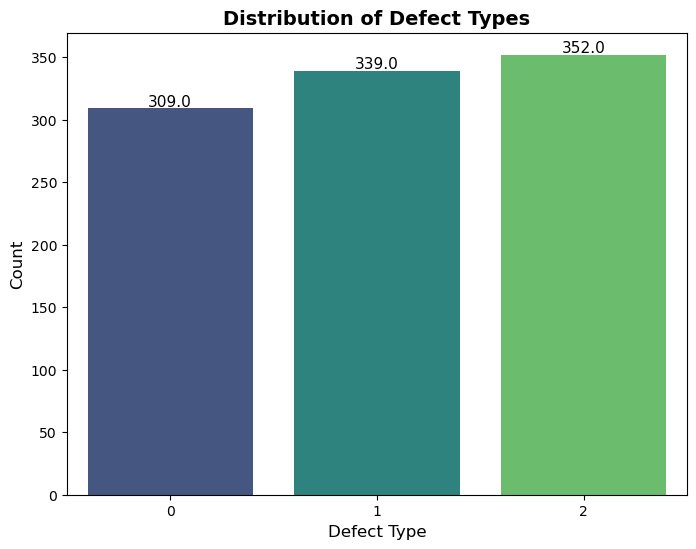

In [21]:
# Exploratory Data Analysis (EDA)

# Basic summary
print("Dataset Shape:", df.shape)
print("\nDataset Info:")
df.info()

# Summary statistics
print("\nSummary Statistics:")
print(df.describe())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Distribution of defect types with annotations
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=df, x="defect_type", palette="viridis")
plt.title("Distribution of Defect Types", fontsize=14, fontweight='bold')
plt.xlabel("Defect Type", fontsize=12)
plt.ylabel("Count", fontsize=12)

# Annotate each bar with its value
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=11, color='black', 
                xytext=(0, 5), textcoords='offset points')

plt.show()

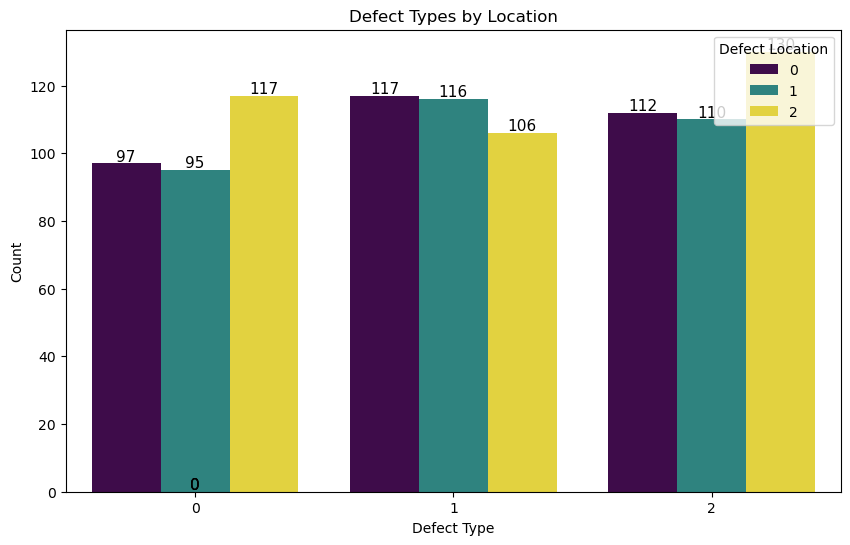

In [22]:
# Defect Types by Location with annotations
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df, x='defect_type', hue='defect_location', palette='viridis')
plt.title('Defect Types by Location')
plt.xlabel('Defect Type')
plt.ylabel('Count')
plt.legend(title='Defect Location', loc='upper right')

# Annotate each bar with its value
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=11, color='black', 
                xytext=(0, 5), textcoords='offset points')

plt.show()

C:\Users\milto\AppData\Local\Temp\ipykernel_18792\694589497.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=monthly_counts.index, y=monthly_counts.values, palette="ocean")


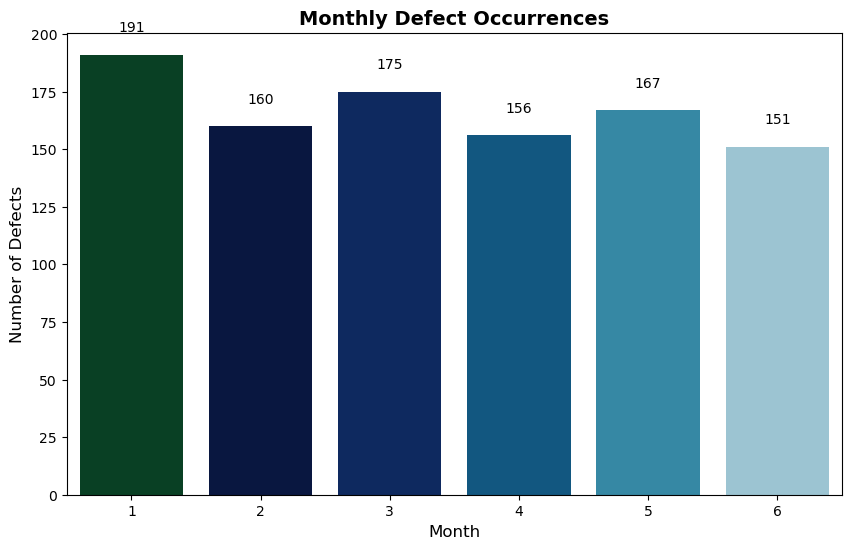

In [9]:
# Monthly distribution of defects
monthly_counts = df.groupby('defect_month').size()

plt.figure(figsize=(10, 6))
sns.barplot(x=monthly_counts.index, y=monthly_counts.values, palette="ocean")
plt.title("Monthly Defect Occurrences", fontsize=14, fontweight='bold')
plt.xlabel("Month", fontsize=12)
plt.ylabel("Number of Defects", fontsize=12)
for i, value in enumerate(monthly_counts.values):
    plt.text(i, value + 10, str(value), ha='center', fontsize=10)
plt.show()

C:\Users\milto\AppData\Local\Temp\ipykernel_18792\1670772145.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(data=df, x='defect_type', y='repair_cost', hue='defect_location', ci=None, palette='Spectral')


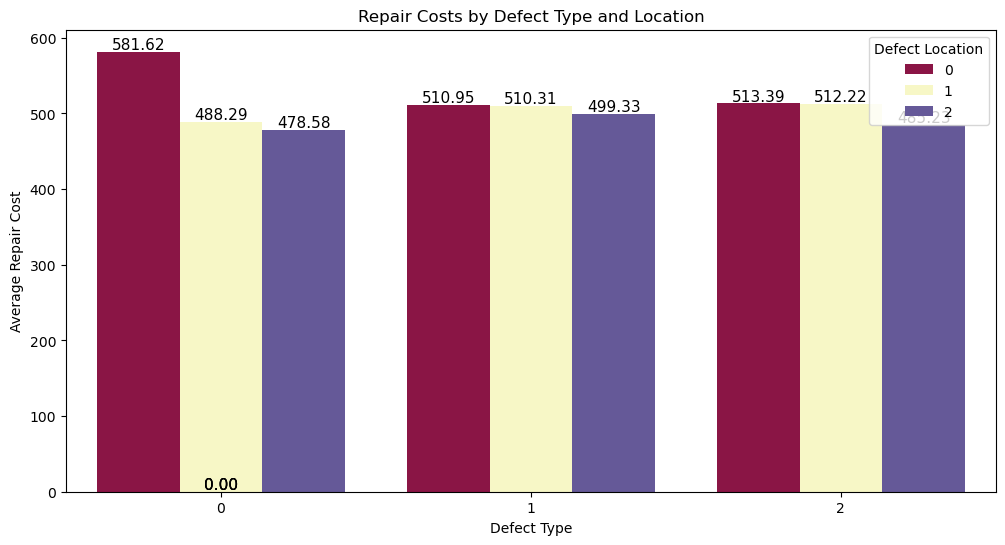

C:\Users\milto\AppData\Local\Temp\ipykernel_18792\1670772145.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="defect_type", y="repair_cost", palette="viridis")


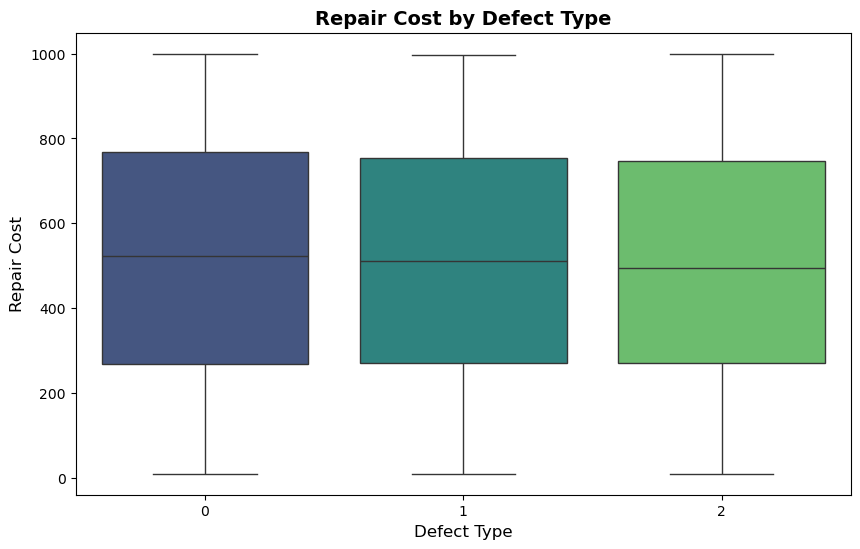

In [24]:
# Repair Costs by Defect Type and Location with annotations
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=df, x='defect_type', y='repair_cost', hue='defect_location', ci=None, palette='Spectral')
plt.title('Repair Costs by Defect Type and Location')
plt.xlabel('Defect Type')
plt.ylabel('Average Repair Cost')
plt.legend(title='Defect Location')

# Annotate each bar with its value
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=11, color='black', 
                xytext=(0, 5), textcoords='offset points')

plt.show()

# Repair cost by defect type
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="defect_type", y="repair_cost", palette="viridis")
plt.title("Repair Cost by Defect Type", fontsize=14, fontweight='bold')
plt.xlabel("Defect Type", fontsize=12)
plt.ylabel("Repair Cost", fontsize=12)
plt.show()

C:\Users\milto\AppData\Local\Temp\ipykernel_18792\823085220.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df, x='defect_month', y='repair_cost', ci=None, hue='defect_type', palette='tab10')


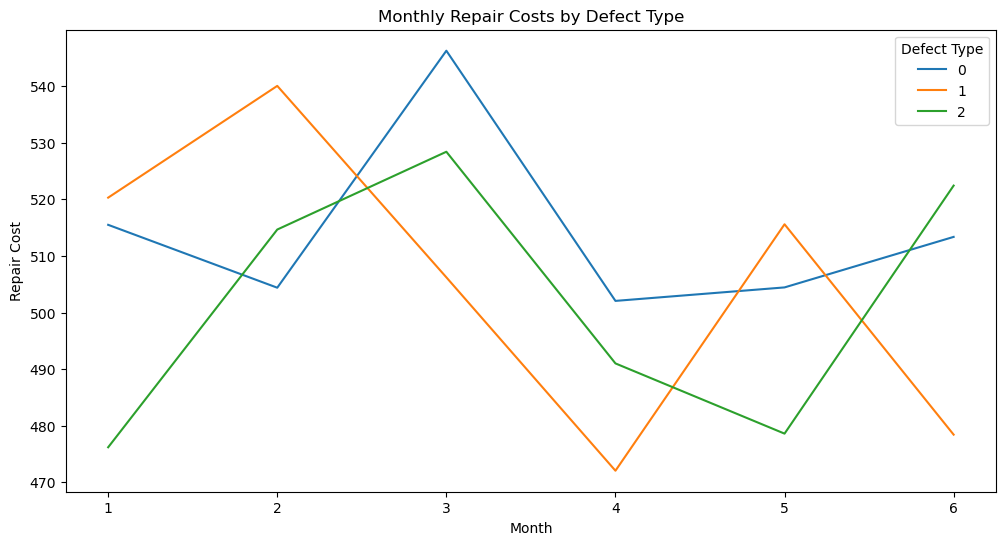

In [16]:
# Defect Frequency Over Time

plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='defect_month', y='repair_cost', ci=None, hue='defect_type', palette='tab10')
plt.title('Monthly Repair Costs by Defect Type')
plt.xlabel('Month')
plt.ylabel('Repair Cost')
plt.legend(title='Defect Type')
plt.show()

C:\Users\milto\AppData\Local\Temp\ipykernel_18792\77227650.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=top_products.index, y=top_products.values, palette='mako')


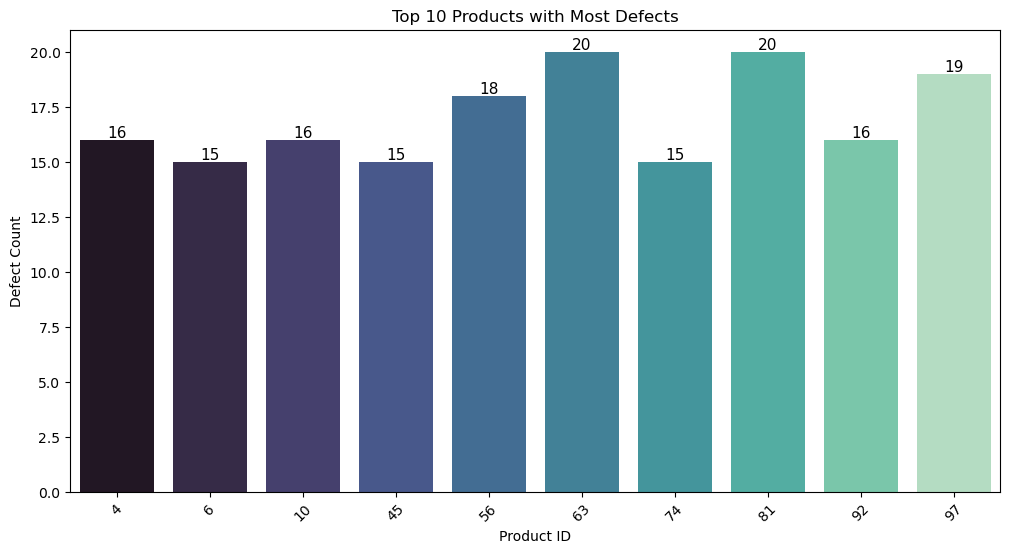

In [23]:
# Defect Counts by Product with annotations
plt.figure(figsize=(12, 6))
top_products = df['product_id'].value_counts().head(10)
ax = sns.barplot(x=top_products.index, y=top_products.values, palette='mako')
plt.title('Top 10 Products with Most Defects')
plt.xlabel('Product ID')
plt.ylabel('Defect Count')
plt.xticks(rotation=45)

# Annotate each bar with its value
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=11, color='black', 
                xytext=(0, 5), textcoords='offset points')

plt.show()


In [26]:
from collections import Counter

# Data Splitting and Scaling

# Separate features and target
X = df.drop(columns=['severity'])
y = df['severity']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Inspect class distribution before SMOTE
print("Class Distribution in Training Set Before SMOTE:", Counter(y_train))

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Inspect class distribution after SMOTE
print("Class Distribution in Training Set After SMOTE:", Counter(y_train_balanced))

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

# Inspect scaled data
print("\nScaled Training Data - Mean:", X_train_scaled.mean(axis=0))
print("\nScaled Training Data - Standard Deviation:", X_train_scaled.std(axis=0))


Class Distribution in Training Set Before SMOTE: Counter({1: 286, 0: 267, 2: 247})
Class Distribution in Training Set After SMOTE: Counter({0: 286, 2: 286, 1: 286})

Scaled Training Data - Mean: [ 9.10952225e-17  5.79696871e-17 -8.69545306e-17  1.65627677e-16
  2.48441516e-17 -3.00200165e-17  0.00000000e+00 -9.10952225e-17
  7.24621088e-17]

Scaled Training Data - Standard Deviation: [1. 1. 1. 1. 1. 1. 0. 1. 1.]


Fitting 5 folds for each of 108 candidates, totalling 540 fits


C:\Users\milto\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:45:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Best Parameters from Grid Search:
{'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.8}

Classification Report:
              precision    recall  f1-score   support

           0       0.33      1.00      0.50        66
           1       0.00      0.00      0.00        72
           2       0.00      0.00      0.00        62

    accuracy                           0.33       200
   macro avg       0.11      0.33      0.17       200
weighted avg       0.11      0.33      0.16       200



C:\Users\milto\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\milto\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\milto\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


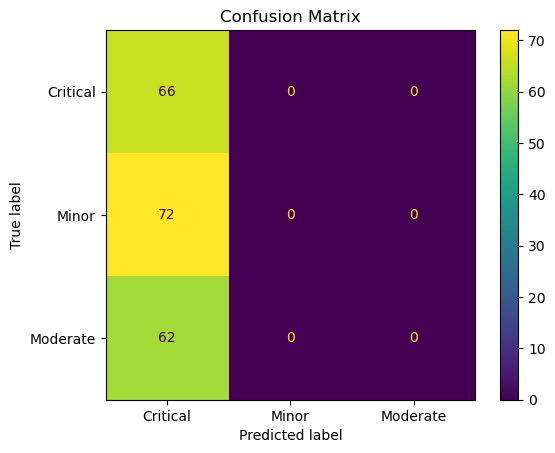

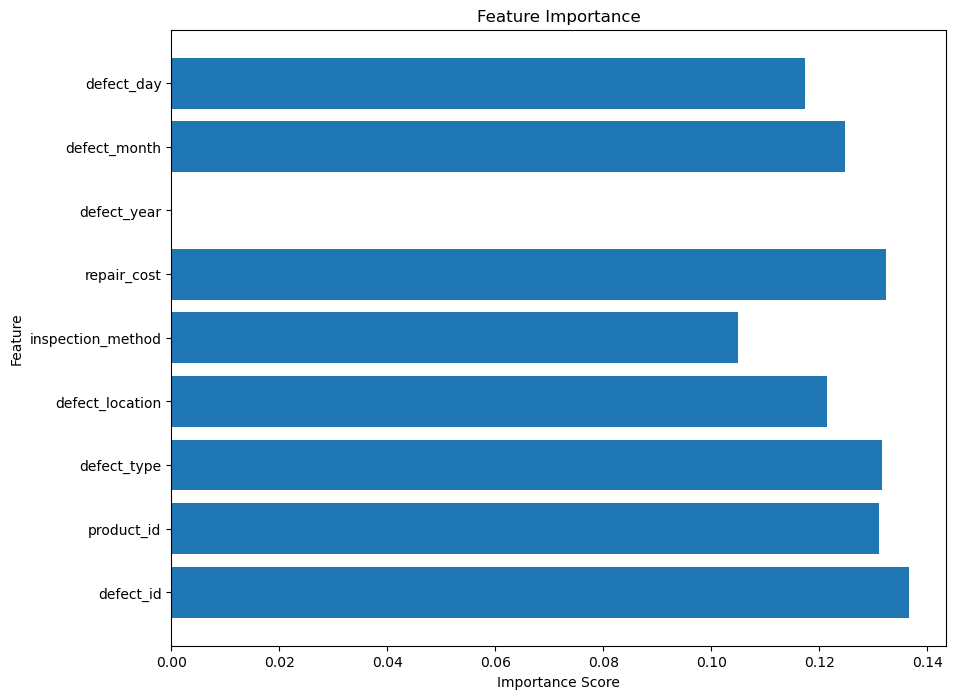

In [27]:
# Hyperparameter Tuning with XGBoost

from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import joblib

# Initialize XGBoost classifier
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')

# Define parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Perform Grid Search
grid_search = GridSearchCV(
    estimator=xgb_model, 
    param_grid=param_grid, 
    cv=5, 
    scoring='f1_weighted', 
    n_jobs=-1, 
    verbose=1
)
grid_search.fit(X_train_balanced, y_train_balanced)

# Output best parameters and model
print("\nBest Parameters from Grid Search:")
print(grid_search.best_params_)

# Evaluate the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Save the best model
joblib.dump(best_model, 'xgb_best_model.pkl')

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoders['severity'].classes_)
disp.plot(cmap='viridis')
plt.title('Confusion Matrix')
plt.show()

# Feature Importance
plt.figure(figsize=(10, 8))
plt.barh(df.drop(columns=['severity']).columns, best_model.feature_importances_)
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

In [ ]:
# Additional Informaiton

# Limitations of the Current Model
# Low Predictive Accuracy:
# The low accuracy and balanced F1-scores indicate the model has limited ability to distinguish between severity levels.
# Feature Engineering:
# The current features may not fully capture the complexity of defect severity. Additional features such as:
# Production line settings.
# Environmental conditions.
# Operator skill levels.
# These could improve predictions.

# Data Imbalance:
# If certain severity levels dominate the dataset, the model may not learn patterns for minority classes effectively.

# Next Steps to Improve the Model
# 1. Improve Data Quality and Feature Engineering
# Add features such as:
# Material properties.
# Defect dimensions.
# Historical defect patterns for specific products or lines.
# 2. Address Class Imbalance
# Explore advanced sampling techniques such as ADASYN or Tomek links to balance classes.
# Alternatively, use cost-sensitive learning methods that penalize misclassifications of severe defects.
# 3. Ensemble Models
# Combine multiple models (e.g., Random Forest, Gradient Boosting, and XGBoost) in an ensemble to improve predictive accuracy.
# 4. Refine the Target Variable
# Severity levels could be grouped or refined to reduce ambiguity between classes, improving the model's ability to learn meaningful patterns.

In [ ]:
# Next Steps to Improve the Model
# 1. Improve Data Quality and Feature Engineering
# Add features such as:
# Material properties.
# Defect dimensions.
# Historical defect patterns for specific products or lines.
# 2. Address Class Imbalance
# Explore advanced sampling techniques such as ADASYN or Tomek links to balance classes.
# Alternatively, use cost-sensitive learning methods that penalize misclassifications of severe defects.
# 3. Ensemble Models
# Combine multiple models (e.g., Random Forest, Gradient Boosting, and XGBoost) in an ensemble to improve predictive accuracy.
# 4. Refine the Target Variable
# Severity levels could be grouped or refined to reduce ambiguity between classes, improving the model's ability to learn meaningful patterns.